## Lesson 4. Crop Spatial Raster Data With a Shapefile

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
sns.set(font_scale = 1.5)

In [3]:
data_path = et.data.get_data('colorado-flood')#, replace=True)

In [4]:
lidar_chm_path = os.path.join(data_path,
                              'spatial',
                              'boulder-leehill-rd',
                              'outputs',
                              'lidar_chm.tif')
lidar_chm_im = rxr.open_rasterio(lidar_chm_path, masked=True).squeeze()

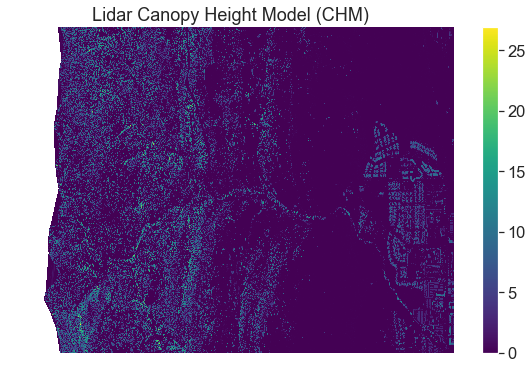

In [5]:
f, ax = plt.subplots(figsize=(10,6))

lidar_chm_im.plot.imshow(ax=ax)

ax.set(title='Lidar Canopy Height Model (CHM)')

ax.set_axis_off()
plt.show()

Open vector layer to crop with

In [6]:
aoi = os.path.join(data_path,
                   'spatial',
                   'boulder-leehill-rd',
                   'clip-extent.shp')
crop_extent = gpd.read_file(aoi)

In [7]:
crop_extent.crs

<Projected CRS: EPSG:32613>
Name: WGS 84 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 108°W to 102°W - by country
- bounds: (-108.0, 0.0, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
lidar_chm_im.rio.crs

CRS.from_epsg(32613)

Plot the crop boundary layer

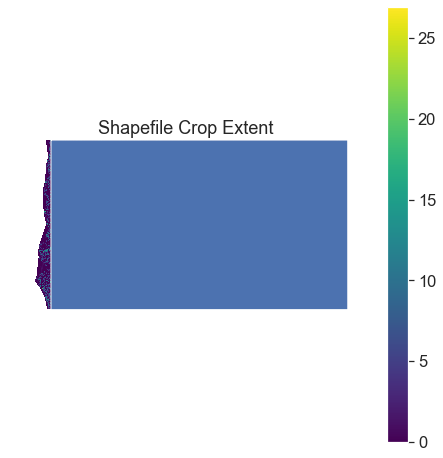

In [9]:
f, ax = plt.subplots(figsize=(8,8))

lidar_chm_im.plot.imshow(ax=ax)
crop_extent.plot(ax=ax)

ax.set(title='Shapefile Crop Extent')
ax.set_axis_off()

plt.show()

Clip raster data using <code>.clip</code>

To perform a clip:
- Open raster using xarray or rioxarray
- Open shapefile as GeoDataFrame
- Crop using rio.clip()

In [10]:
lidar_clipped = lidar_chm_im.rio.clip(crop_extent.geometry.apply(mapping),
                                      crop_extent.crs) # Not  acutally needed unless CRS are different

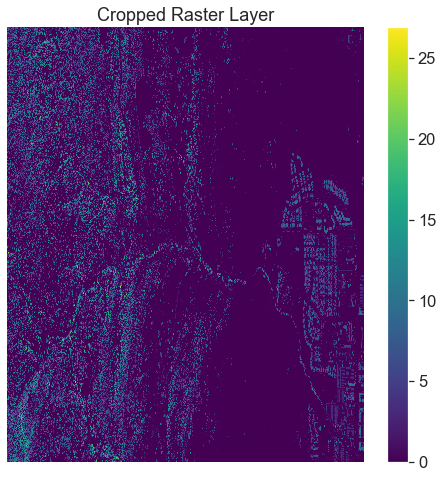

In [11]:
f, ax = plt.subplots(figsize=(8,8))

lidar_clipped.plot(ax=ax)
ax.set(title='Cropped Raster Layer')
ax.set_axis_off()
plt.show()

In [12]:
export_tif_path = os.path.join(data_path,
                               'spatial',
                               'outputs',
                               'lidar_chm_cropped.tif')

lidar_clipped.rio.to_raster(export_tif_path)

Open exported data

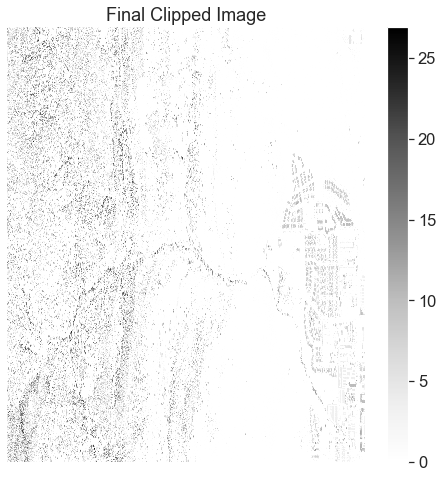

In [13]:
clipped_chm = rxr.open_rasterio(export_tif_path, masked=True).squeeze()

f, ax = plt.subplots(figsize=(8,8))
clipped_chm.plot.imshow(ax=ax, cmap='Greys')
ax.set(title='Final Clipped Image')
ax.set_axis_off()
plt.show()

### Optional Challenge

Recreate plots from last lesson but cropped

In [14]:
pre_dtm_path = os.path.join(data_path,
                            'spatial',
                            'boulder-leehill-rd',
                            'pre-flood',
                            'lidar',
                            'pre_DTM.tif')
pre_dsm_path = os.path.join(data_path,
                            'spatial',
                            'boulder-leehill-rd',
                            'pre-flood',
                            'lidar',
                            'pre_DSM.tif')
post_dtm_path = os.path.join(data_path,
                             'spatial',
                             'boulder-leehill-rd',
                             'post-flood',
                             'lidar',
                             'post_DTM.tif')
post_dsm_path = os.path.join(data_path,
                             'spatial',
                             'boulder-leehill-rd',
                             'post-flood',
                             'lidar',
                             'post_DSM.tif')

In [15]:
pre_dtm = rxr.open_rasterio(pre_dtm_path, masked=True).squeeze()
pre_dsm = rxr.open_rasterio(pre_dsm_path, masked=True).squeeze()
post_dtm = rxr.open_rasterio(post_dtm_path, masked=True).squeeze()
post_dsm = rxr.open_rasterio(post_dsm_path, masked=True).squeeze()

In [16]:
pre_chm = pre_dsm - pre_dtm
post_chm = post_dsm - post_dtm
chm_change = post_chm - pre_chm

In [17]:
dtm_change = post_dtm - pre_dtm

In [18]:
chm_change.rio.crs

CRS.from_epsg(32613)

In [19]:
dtm_change.rio.crs

CRS.from_epsg(32613)

In [20]:
crop_extent_path = os.path.join(data_path,
                                'spatial',
                                'boulder-leehill-rd',
                                'clip-extent.shp')
crop_extent = gpd.read_file(crop_extent_path)

In [21]:
crop_extent.crs

<Projected CRS: EPSG:32613>
Name: WGS 84 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 108°W to 102°W - by country
- bounds: (-108.0, 0.0, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
chm_change_clipped = chm_change.rio.clip(crop_extent.geometry.apply(mapping))

In [23]:
dtm_change_clipped = dtm_change.rio.clip(crop_extent.geometry.apply(mapping))

Should I clip before or after the classification? Likely doesn't matter.

In [24]:
class_bins = [-np.inf] + [-10,-3, -1, 0, 1, 3,10] + [np.inf]

In [25]:
chm_change_class = xr.apply_ufunc(np.digitize,
                                  chm_change_clipped,
                                  class_bins)
dtm_change_class = xr.apply_ufunc(np.digitize,
                                  dtm_change_clipped,
                                  class_bins)

In [33]:
norm_bins = [x+0.5 for x in list(range(9))]
change_labels = ['< -10', '-10 to -3', '-3 to -1', '-1 to 0', '0 to 1', '1 to 3', '3 to 10', '> 10' ]

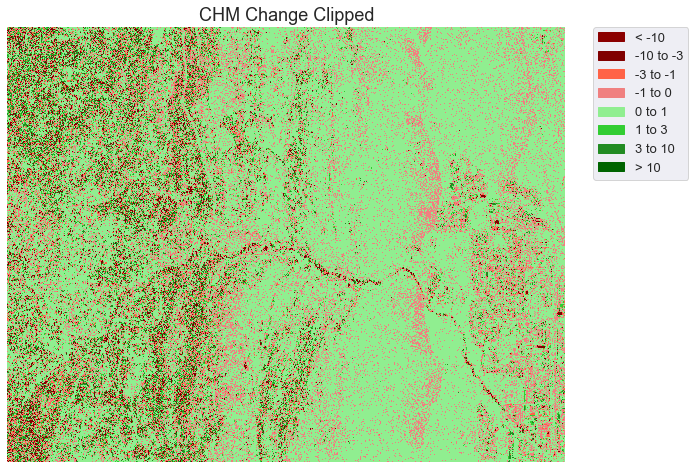

In [36]:
colours = ['darkred', 'maroon', 'tomato', 'lightcoral', 'lightgreen', 'limegreen', 'forestgreen', 'darkgreen']
cmap = ListedColormap(colours)
norm = BoundaryNorm(norm_bins, len(colours))

f, ax = plt.subplots(figsize=(10,8))

im = chm_change_class.plot.imshow(ax=ax,
                                 cmap=cmap,
                                 norm=norm,
                                 add_colorbar = False)
ep.draw_legend(im, titles=change_labels)
ax.set(title = 'CHM Change Clipped')
ax.set_axis_off()
plt.show()

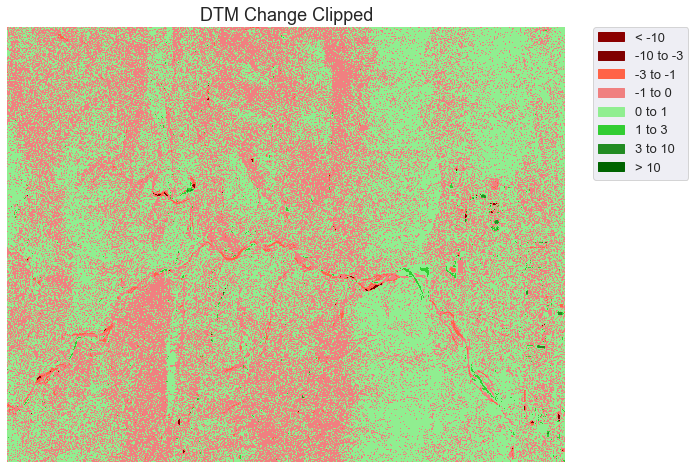

In [39]:
colours = ['darkred', 'maroon', 'tomato', 'lightcoral', 'lightgreen', 'limegreen', 'forestgreen', 'darkgreen']
cmap = ListedColormap(colours)
norm = BoundaryNorm(norm_bins, len(colours))

f, ax = plt.subplots(figsize=(10,8))

im = dtm_change_class.plot.imshow(ax=ax,
                                 cmap=cmap,
                                 norm=norm,
                                 add_colorbar = False)
ep.draw_legend(im, titles = change_labels)
ax.set(title = 'DTM Change Clipped')
ax.set_axis_off()
plt.show()